In [7]:
using Pkg
Pkg.activate(".")

  Activating project at `~/Desktop/julia_codes/GaussianExpansionCavityMethod.jl/examples/2Spin`


In [8]:
using Revise 
using Random, Graphs, GaussianExpansionCavityMethod, SparseArrays, LinearAlgebra, DifferentialEquations, DifferentialEquations.EnsembleAnalysis
import PyPlot as plt

In [9]:
function gen_J(N, K, J_params; rng=Xoshiro(1234))
    J = adjacency_matrix(random_regular_graph(N, K; rng=rng), Float64)
    @inbounds @fastmath for i in 1:N
        @inbounds @fastmath for j in i+1:N
            if J[i, j] ≠ 0
                Jval = J_params[1]/sqrt(K) * (rand(rng) < 0.5 ? 1 : -1)
                J[i, j] = Jval
                J[j, i] = Jval
            end
        end
    end
    dropzeros!(J)
    return J
end

gen_J (generic function with 1 method)

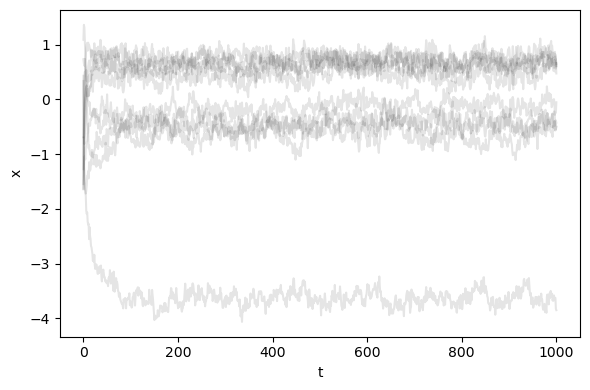

In [10]:
N, K = 100, 3

rng = Xoshiro(1234)

J, D = 1.0, 0.01
Jmat = gen_J(N, K, [J]; rng=rng)

model = TwoSpinModel(K, Jmat, D)


x0_min, x0_max = -3.0, 3.0
x0 = rand(rng, N) .* (x0_max - x0_min) .+ x0_min
x0 .*= sqrt(N / sum(x0 .^ 2))
tmax = 1000.0 
tsave=collect(range(0.0, tmax; length=1000))

tvec, trajs = sample_2Spin(model, x0, tmax, tsave; rng=rng)

fig, ax = plt.subplots(1, 1, figsize=(6, 4), tight_layout=true)
for i in 1:10
    ax.plot(tvec, view(trajs, i, :), color="k", alpha=0.1)
end
ax.set_xlabel("t")
ax.set_ylabel("x")

display(fig)

In [45]:
N, K = 1000, 10

rng = Xoshiro(1234) 
J, D = 1.0, 0.01

x0_min, x0_max = 1.0, 1.0
dt = 1e-2
tmax = 10000.0
tsave = collect(range(0.0, tmax; length=8000))

nsim = 20;

In [ ]:
# Define ensemble model
model_ensemble = TwoSpinModelRRG(N, K, J, D)

# Sample ensemble
tvals_alls, traj_alls, lambda_traj_alls = sample_ensemble_2Spin(model_ensemble, x0_min, x0_max, tmax, tsave, nsim; rng=rng, showprogress=true, dt=dt);

Progress:  20%|█████▍                     |  ETA: 0:03:16 (12.26  s/it)

CompositeException: TaskFailedException

    nested task error: InterruptException:
    Stacktrace:
     [1] update_lambda(u::Vector{Float64}, dW::Vector{Float64}, dt::Float64, model::TwoSpinModel)
       @ GaussianExpansionCavityMethod ~/Desktop/julia_codes/GaussianExpansionCavityMethod.jl/src/2Spin/sample.jl:4
     [2] sample_2Spin(model::TwoSpinModel, x0::Vector{Float64}, tmax::Float64, tsave::Vector{Float64}; rng::Xoshiro, dt::Float64)
       @ GaussianExpansionCavityMethod ~/Desktop/julia_codes/GaussianExpansionCavityMethod.jl/src/2Spin/sample.jl:80
     [3] sample_2Spin
       @ ~/Desktop/julia_codes/GaussianExpansionCavityMethod.jl/src/2Spin/sample.jl:34 [inlined]
     [4] macro expansion
       @ ~/Desktop/julia_codes/GaussianExpansionCavityMethod.jl/src/2Spin/sample.jl:153 [inlined]
     [5] (::GaussianExpansionCavityMethod.var"#252#threadsfor_fun#202"{GaussianExpansionCavityMethod.var"#252#threadsfor_fun#192#203"{Float64, ProgressMeter.Progress, ReentrantLock, Vector{UInt32}, Vector{Vector{Float64}}, Vector{Vector{Float64}}, Vector{Matrix{Float64}}, Vector{Xoshiro}, Vector{Float64}, Vector{Vector{Float64}}, Vector{Tuple{Float64, Float64}}, Vector{TwoSpinModelEnsemble}, UnitRange{Int64}}})(tid::Int64; onethread::Bool)
       @ GaussianExpansionCavityMethod threadingconstructs.jl:206
     [6] #252#threadsfor_fun
       @ ./threadingconstructs.jl:173 [inlined]
     [7] (::Base.Threads.var"#1#2"{GaussianExpansionCavityMethod.var"#252#threadsfor_fun#202"{GaussianExpansionCavityMethod.var"#252#threadsfor_fun#192#203"{Float64, ProgressMeter.Progress, ReentrantLock, Vector{UInt32}, Vector{Vector{Float64}}, Vector{Vector{Float64}}, Vector{Matrix{Float64}}, Vector{Xoshiro}, Vector{Float64}, Vector{Vector{Float64}}, Vector{Tuple{Float64, Float64}}, Vector{TwoSpinModelEnsemble}, UnitRange{Int64}}}, Int64})()
       @ Base.Threads ./threadingconstructs.jl:145

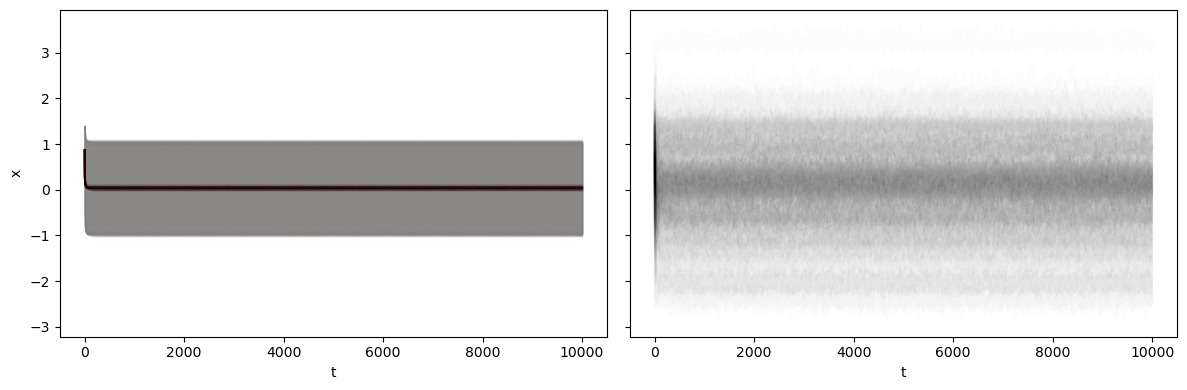

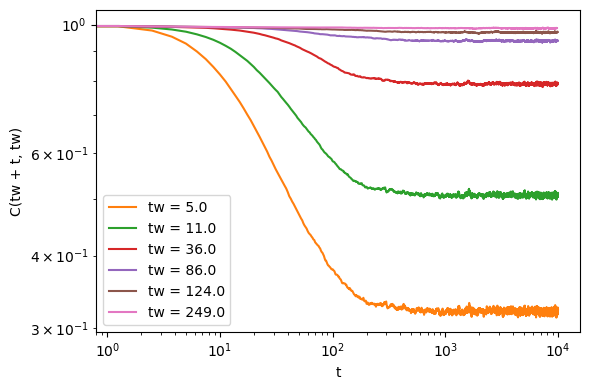

In [42]:

fig, axs = plt.subplots(1, 2, figsize=(6*2, 4), tight_layout=true, sharey=true)
# Only averages
ax = axs[1]
mean_traj, std_traj, autocorr_traj = compute_stats(traj_alls)
ax.plot(tvals_alls[1], mean_traj, color="red")
ax.fill_between(tvals_alls[1], mean_traj .- std_traj, mean_traj .+ std_traj, color="red", alpha=0.1)
for isim in 1:nsim
    mean, std, autocorr = compute_stats(traj_alls[isim])
    ax.plot(tvals_alls[isim], mean, color="k", alpha=0.1)
    ax.fill_between(tvals_alls[isim], mean .- std, mean .+ std, color="gray", alpha=0.1)
end
ax.set_xlabel("t")
ax.set_ylabel("x")
# Method 2
ax = axs[2]
for isim in 1:nsim
    for i in 1:10
        ax.plot(tvals_alls[isim], view(traj_alls[isim],i,:), color="k", alpha=0.01)
    end
end
ax.set_xlabel("t")
plt.display(fig)

# Plotting the correlation function at different waiting times and lambdas
tw_idxs = [5, 10, 30, 70, 100, 200]
tws = tsave[tw_idxs]
fig, axs = plt.subplots(1, 2, figsize=(6*2, 4), tight_layout=true)
# Plot the correlation function at different waiting times
mean_traj, std_traj, autocorr_traj = compute_stats(traj_alls)
for (i, (tw, tw_idx)) in enumerate(Iterators.zip(tws, tw_idxs))
    ax.plot(tsave[tw_idx:end] .- tw, autocorr_traj[tw_idx:end, tw_idx] ./ autocorr_traj[tw_idx, tw_idx], color="C$i", label="tw = $(round(tw, digits=0))")
end
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("t")
ax.set_ylabel("C(tw + t, tw)")
ax.legend()
plt.display(fig)

# Plot lambdas
